# Navigation — Deep Reinforcement Learning

This notebook trains a **Double DQN agent with Dueling network architecture** to navigate a Unity environment,
collecting yellow bananas (+1) and avoiding blue bananas (-1).

**Solve condition**: Average score >= 13 over 100 consecutive episodes.

### 1. Import Packages and Start Environment

In [1]:
import sys
sys.path.insert(0, './python')

from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import torch

%matplotlib inline

In [2]:
env = UnityEnvironment(file_name="Banana.app")

Mono path[0] = '/Users/twilcoxson/udacity_nd608_projects/grad/deep_reinforcement_learning/p1_navigation/Banana.app/Contents/Resources/Data/Managed'
Mono config path = '/Users/twilcoxson/udacity_nd608_projects/grad/deep_reinforcement_learning/p1_navigation/Banana.app/Contents/MonoBleedingEdge/etc'


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2. Examine the State and Action Spaces

In [3]:
# Get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Reset and examine
env_info = env.reset(train_mode=True)[brain_name]
print('Number of agents:', len(env_info.agents))

action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

state = env_info.vector_observations[0]
state_size = len(state)
print('State size:', state_size)
print('Sample state:', state[:5], '...')

Number of agents: 1
Number of actions: 4
State size: 37
Sample state: [1.         0.         0.         0.         0.84408134] ...


### 3. Initialize the Agent

We use a **Double DQN** agent with a **Dueling network architecture**:

- **Double DQN** decouples action selection (local network) from evaluation (target network), reducing the Q-value overestimation bias inherent in standard DQN.
- **Dueling Architecture** separates state value V(s) from action advantage A(s,a), allowing the agent to learn which states are valuable without evaluating every action — particularly helpful when many actions have similar outcomes.

The agent uses an experience replay buffer (100K transitions) and soft target updates (τ=0.001).

In [4]:
from dqn_agent import Agent

agent = Agent(state_size=state_size, action_size=action_size, seed=42)

# Print network architecture
print(agent.qnetwork_local)
total_params = sum(p.numel() for p in agent.qnetwork_local.parameters())
print(f'\nTotal parameters: {total_params:,}')

DuelingQNetwork(
  (fc1): Linear(in_features=37, out_features=128, bias=True)
  (value_fc): Linear(in_features=128, out_features=64, bias=True)
  (value_out): Linear(in_features=64, out_features=1, bias=True)
  (advantage_fc): Linear(in_features=128, out_features=64, bias=True)
  (advantage_out): Linear(in_features=64, out_features=4, bias=True)
)

Total parameters: 21,701


### 4. Train the Agent

The training loop uses an epsilon-greedy policy with decaying exploration.
Training continues until the 100-episode average reaches 15.0 (well above the 13.0 solve threshold) for a robust policy. The best checkpoint is saved incrementally.

In [5]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Train with Double DQN.
    
    Args:
        n_episodes: maximum number of training episodes
        max_t: maximum timesteps per episode
        eps_start: starting epsilon
        eps_end: minimum epsilon
        eps_decay: multiplicative decay factor per episode
    """
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    best_avg = -float('inf')
    solved = False
    
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay * eps)
        avg = np.mean(scores_window)
        
        print(f'\rEpisode {i_episode}\tAverage Score: {avg:.2f}', end='')
        if i_episode % 100 == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {avg:.2f}')
        
        if not solved and avg >= 13.0:
            print(f'\n*** Environment solved in {i_episode - 100} episodes! ***')
            print(f'Average Score: {avg:.2f}')
            solved = True
        
        # Save best model once we pass threshold
        if len(scores_window) == 100 and avg > best_avg and avg >= 13.0:
            best_avg = avg
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
        
        # Stop training at 15.0 for robust policy
        if avg >= 15.0:
            print(f'\nTarget 15.0 reached at episode {i_episode}! Avg: {avg:.2f}')
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    
    return scores

scores = dqn()

Episode 1	Average Score: 0.00

Episode 2	Average Score: 1.00

Episode 3	Average Score: 0.67

Episode 4	Average Score: 0.50

Episode 5	Average Score: 0.20

Episode 6	Average Score: 0.00

Episode 7	Average Score: 0.14

Episode 8	Average Score: 0.25

Episode 9	Average Score: 0.11

Episode 10	Average Score: 0.20

Episode 11	Average Score: 0.27

Episode 12	Average Score: 0.25

Episode 13	Average Score: 0.15

Episode 14	Average Score: 0.14

Episode 15	Average Score: 0.13

Episode 16	Average Score: 0.19

Episode 17	Average Score: 0.18

Episode 18	Average Score: 0.17

Episode 19	Average Score: 0.11

Episode 20	Average Score: 0.10

Episode 21	Average Score: 0.19

Episode 22	Average Score: 0.14

Episode 23	Average Score: 0.00

Episode 24	Average Score: 0.00

Episode 25	Average Score: 0.00

Episode 26	Average Score: 0.00

Episode 27	Average Score: 0.04

Episode 28	Average Score: 0.11

Episode 29	Average Score: 0.03

Episode 30	Average Score: 0.03

Episode 31	Average Score: 0.06

Episode 32	Average Score: 0.09

Episode 33	Average Score: 0.12

Episode 34	Average Score: 0.15

Episode 35	Average Score: 0.14

Episode 36	Average Score: 0.19

Episode 37	Average Score: 0.16

Episode 38	Average Score: 0.18

Episode 39	Average Score: 0.18

Episode 40	Average Score: 0.20

Episode 41	Average Score: 0.17

Episode 42	Average Score: 0.12

Episode 43	Average Score: 0.12

Episode 44	Average Score: 0.07

Episode 45	Average Score: 0.09

Episode 46	Average Score: 0.07

Episode 47	Average Score: 0.06

Episode 48	Average Score: 0.08

Episode 49	Average Score: 0.10

Episode 50	Average Score: 0.12

Episode 51	Average Score: 0.14

Episode 52	Average Score: 0.15

Episode 53	Average Score: 0.13

Episode 54	Average Score: 0.17

Episode 55	Average Score: 0.16

Episode 56	Average Score: 0.21

Episode 57	Average Score: 0.23

Episode 58	Average Score: 0.26

Episode 59	Average Score: 0.27

Episode 60	Average Score: 0.27

Episode 61	Average Score: 0.31

Episode 62	Average Score: 0.34

Episode 63	Average Score: 0.33

Episode 64	Average Score: 0.34

Episode 65	Average Score: 0.38

Episode 66	Average Score: 0.39

Episode 67	Average Score: 0.39

Episode 68	Average Score: 0.38

Episode 69	Average Score: 0.42

Episode 70	Average Score: 0.43

Episode 71	Average Score: 0.45

Episode 72	Average Score: 0.47

Episode 73	Average Score: 0.48

Episode 74	Average Score: 0.49

Episode 75	Average Score: 0.48

Episode 76	Average Score: 0.50

Episode 77	Average Score: 0.49

Episode 78	Average Score: 0.49

Episode 79	Average Score: 0.52

Episode 80	Average Score: 0.53

Episode 81	Average Score: 0.56

Episode 82	Average Score: 0.57

Episode 83	Average Score: 0.54

Episode 84	Average Score: 0.55

Episode 85	Average Score: 0.55

Episode 86	Average Score: 0.55

Episode 87	Average Score: 0.54

Episode 88	Average Score: 0.56

Episode 89	Average Score: 0.56

Episode 90	Average Score: 0.54

Episode 91	Average Score: 0.56

Episode 92	Average Score: 0.61

Episode 93	Average Score: 0.61

Episode 94	Average Score: 0.63

Episode 95	Average Score: 0.61

Episode 96	Average Score: 0.60

Episode 97	Average Score: 0.61

Episode 98	Average Score: 0.63

Episode 99	Average Score: 0.66

Episode 100	Average Score: 0.68


Episode 101	Average Score: 0.68

Episode 102	Average Score: 0.69

Episode 103	Average Score: 0.73

Episode 104	Average Score: 0.75

Episode 105	Average Score: 0.78

Episode 106	Average Score: 0.79

Episode 107	Average Score: 0.79

Episode 108	Average Score: 0.80

Episode 109	Average Score: 0.81

Episode 110	Average Score: 0.80

Episode 111	Average Score: 0.80

Episode 112	Average Score: 0.84

Episode 113	Average Score: 0.89

Episode 114	Average Score: 0.91

Episode 115	Average Score: 0.93

Episode 116	Average Score: 0.95

Episode 117	Average Score: 0.95

Episode 118	Average Score: 0.99

Episode 119	Average Score: 1.06

Episode 120	Average Score: 1.10

Episode 121	Average Score: 1.09

Episode 122	Average Score: 1.15

Episode 123	Average Score: 1.18

Episode 124	Average Score: 1.19

Episode 125	Average Score: 1.22

Episode 126	Average Score: 1.28

Episode 127	Average Score: 1.31

Episode 128	Average Score: 1.33

Episode 129	Average Score: 1.36

Episode 130	Average Score: 1.37

Episode 131	Average Score: 1.39

Episode 132	Average Score: 1.44

Episode 133	Average Score: 1.44

Episode 134	Average Score: 1.47

Episode 135	Average Score: 1.49

Episode 136	Average Score: 1.48

Episode 137	Average Score: 1.50

Episode 138	Average Score: 1.49

Episode 139	Average Score: 1.52

Episode 140	Average Score: 1.53

Episode 141	Average Score: 1.58

Episode 142	Average Score: 1.61

Episode 143	Average Score: 1.61

Episode 144	Average Score: 1.67

Episode 145	Average Score: 1.71

Episode 146	Average Score: 1.75

Episode 147	Average Score: 1.74

Episode 148	Average Score: 1.77

Episode 149	Average Score: 1.80

Episode 150	Average Score: 1.86

Episode 151	Average Score: 1.89

Episode 152	Average Score: 1.88

Episode 153	Average Score: 1.90

Episode 154	Average Score: 1.89

Episode 155	Average Score: 1.99

Episode 156	Average Score: 1.98

Episode 157	Average Score: 2.00

Episode 158	Average Score: 2.03

Episode 159	Average Score: 2.05

Episode 160	Average Score: 2.13

Episode 161	Average Score: 2.10

Episode 162	Average Score: 2.08

Episode 163	Average Score: 2.13

Episode 164	Average Score: 2.20

Episode 165	Average Score: 2.23

Episode 166	Average Score: 2.24

Episode 167	Average Score: 2.29

Episode 168	Average Score: 2.32

Episode 169	Average Score: 2.30

Episode 170	Average Score: 2.32

Episode 171	Average Score: 2.34

Episode 172	Average Score: 2.37

Episode 173	Average Score: 2.43

Episode 174	Average Score: 2.44

Episode 175	Average Score: 2.49

Episode 176	Average Score: 2.49

Episode 177	Average Score: 2.55

Episode 178	Average Score: 2.59

Episode 179	Average Score: 2.64

Episode 180	Average Score: 2.76

Episode 181	Average Score: 2.80

Episode 182	Average Score: 2.82

Episode 183	Average Score: 2.90

Episode 184	Average Score: 2.90

Episode 185	Average Score: 2.95

Episode 186	Average Score: 3.02

Episode 187	Average Score: 3.15

Episode 188	Average Score: 3.19

Episode 189	Average Score: 3.23

Episode 190	Average Score: 3.26

Episode 191	Average Score: 3.29

Episode 192	Average Score: 3.32

Episode 193	Average Score: 3.35

Episode 194	Average Score: 3.36

Episode 195	Average Score: 3.39

Episode 196	Average Score: 3.44

Episode 197	Average Score: 3.52

Episode 198	Average Score: 3.53

Episode 199	Average Score: 3.53

Episode 200	Average Score: 3.56


Episode 201	Average Score: 3.63

Episode 202	Average Score: 3.67

Episode 203	Average Score: 3.64

Episode 204	Average Score: 3.66

Episode 205	Average Score: 3.67

Episode 206	Average Score: 3.72

Episode 207	Average Score: 3.79

Episode 208	Average Score: 3.83

Episode 209	Average Score: 3.91

Episode 210	Average Score: 3.95

Episode 211	Average Score: 4.05

Episode 212	Average Score: 4.06

Episode 213	Average Score: 4.13

Episode 214	Average Score: 4.12

Episode 215	Average Score: 4.17

Episode 216	Average Score: 4.20

Episode 217	Average Score: 4.24

Episode 218	Average Score: 4.21

Episode 219	Average Score: 4.25

Episode 220	Average Score: 4.27

Episode 221	Average Score: 4.33

Episode 222	Average Score: 4.37

Episode 223	Average Score: 4.43

Episode 224	Average Score: 4.47

Episode 225	Average Score: 4.52

Episode 226	Average Score: 4.51

Episode 227	Average Score: 4.57

Episode 228	Average Score: 4.64

Episode 229	Average Score: 4.69

Episode 230	Average Score: 4.74

Episode 231	Average Score: 4.75

Episode 232	Average Score: 4.81

Episode 233	Average Score: 4.91

Episode 234	Average Score: 4.98

Episode 235	Average Score: 5.06

Episode 236	Average Score: 5.14

Episode 237	Average Score: 5.20

Episode 238	Average Score: 5.31

Episode 239	Average Score: 5.41

Episode 240	Average Score: 5.48

Episode 241	Average Score: 5.49

Episode 242	Average Score: 5.56

Episode 243	Average Score: 5.64

Episode 244	Average Score: 5.69

Episode 245	Average Score: 5.74

Episode 246	Average Score: 5.77

Episode 247	Average Score: 5.84

Episode 248	Average Score: 5.84

Episode 249	Average Score: 5.90

Episode 250	Average Score: 5.88

Episode 251	Average Score: 5.95

Episode 252	Average Score: 6.02

Episode 253	Average Score: 6.13

Episode 254	Average Score: 6.21

Episode 255	Average Score: 6.20

Episode 256	Average Score: 6.28

Episode 257	Average Score: 6.34

Episode 258	Average Score: 6.42

Episode 259	Average Score: 6.47

Episode 260	Average Score: 6.46

Episode 261	Average Score: 6.55

Episode 262	Average Score: 6.59

Episode 263	Average Score: 6.67

Episode 264	Average Score: 6.69

Episode 265	Average Score: 6.68

Episode 266	Average Score: 6.71

Episode 267	Average Score: 6.75

Episode 268	Average Score: 6.81

Episode 269	Average Score: 6.94

Episode 270	Average Score: 6.95

Episode 271	Average Score: 7.03

Episode 272	Average Score: 7.08

Episode 273	Average Score: 7.11

Episode 274	Average Score: 7.17

Episode 275	Average Score: 7.21

Episode 276	Average Score: 7.23

Episode 277	Average Score: 7.23

Episode 278	Average Score: 7.31

Episode 279	Average Score: 7.33

Episode 280	Average Score: 7.33

Episode 281	Average Score: 7.33

Episode 282	Average Score: 7.37

Episode 283	Average Score: 7.43

Episode 284	Average Score: 7.48

Episode 285	Average Score: 7.52

Episode 286	Average Score: 7.58

Episode 287	Average Score: 7.54

Episode 288	Average Score: 7.58

Episode 289	Average Score: 7.64

Episode 290	Average Score: 7.66

Episode 291	Average Score: 7.72

Episode 292	Average Score: 7.80

Episode 293	Average Score: 7.84

Episode 294	Average Score: 7.89

Episode 295	Average Score: 8.01

Episode 296	Average Score: 8.08

Episode 297	Average Score: 8.06

Episode 298	Average Score: 8.09

Episode 299	Average Score: 8.16

Episode 300	Average Score: 8.13


Episode 301	Average Score: 8.09

Episode 302	Average Score: 8.13

Episode 303	Average Score: 8.19

Episode 304	Average Score: 8.17

Episode 305	Average Score: 8.22

Episode 306	Average Score: 8.29

Episode 307	Average Score: 8.28

Episode 308	Average Score: 8.32

Episode 309	Average Score: 8.33

Episode 310	Average Score: 8.36

Episode 311	Average Score: 8.36

Episode 312	Average Score: 8.45

Episode 313	Average Score: 8.41

Episode 314	Average Score: 8.49

Episode 315	Average Score: 8.52

Episode 316	Average Score: 8.61

Episode 317	Average Score: 8.68

Episode 318	Average Score: 8.81

Episode 319	Average Score: 8.80

Episode 320	Average Score: 8.82

Episode 321	Average Score: 8.87

Episode 322	Average Score: 8.89

Episode 323	Average Score: 8.91

Episode 324	Average Score: 8.96

Episode 325	Average Score: 9.04

Episode 326	Average Score: 9.06

Episode 327	Average Score: 9.04

Episode 328	Average Score: 9.04

Episode 329	Average Score: 9.05

Episode 330	Average Score: 9.00

Episode 331	Average Score: 9.07

Episode 332	Average Score: 9.06

Episode 333	Average Score: 9.07

Episode 334	Average Score: 9.06

Episode 335	Average Score: 9.08

Episode 336	Average Score: 9.04

Episode 337	Average Score: 9.06

Episode 338	Average Score: 9.03

Episode 339	Average Score: 9.03

Episode 340	Average Score: 9.06

Episode 341	Average Score: 9.14

Episode 342	Average Score: 9.15

Episode 343	Average Score: 9.19

Episode 344	Average Score: 9.24

Episode 345	Average Score: 9.30

Episode 346	Average Score: 9.32

Episode 347	Average Score: 9.37

Episode 348	Average Score: 9.45

Episode 349	Average Score: 9.45

Episode 350	Average Score: 9.53

Episode 351	Average Score: 9.50

Episode 352	Average Score: 9.49

Episode 353	Average Score: 9.46

Episode 354	Average Score: 9.48

Episode 355	Average Score: 9.53

Episode 356	Average Score: 9.56

Episode 357	Average Score: 9.55

Episode 358	Average Score: 9.55

Episode 359	Average Score: 9.58

Episode 360	Average Score: 9.65

Episode 361	Average Score: 9.68

Episode 362	Average Score: 9.75

Episode 363	Average Score: 9.72

Episode 364	Average Score: 9.72

Episode 365	Average Score: 9.75

Episode 366	Average Score: 9.86

Episode 367	Average Score: 9.92

Episode 368	Average Score: 9.92

Episode 369	Average Score: 9.91

Episode 370	Average Score: 9.95

Episode 371	Average Score: 9.92

Episode 372	Average Score: 9.94

Episode 373	Average Score: 9.90

Episode 374	Average Score: 9.91

Episode 375	Average Score: 9.99

Episode 376	Average Score: 10.08

Episode 377	Average Score: 10.11

Episode 378	Average Score: 10.09

Episode 379	Average Score: 10.15

Episode 380	Average Score: 10.09

Episode 381	Average Score: 10.09

Episode 382	Average Score: 10.09

Episode 383	Average Score: 10.08

Episode 384	Average Score: 10.22

Episode 385	Average Score: 10.23

Episode 386	Average Score: 10.24

Episode 387	Average Score: 10.28

Episode 388	Average Score: 10.24

Episode 389	Average Score: 10.25

Episode 390	Average Score: 10.33

Episode 391	Average Score: 10.34

Episode 392	Average Score: 10.33

Episode 393	Average Score: 10.38

Episode 394	Average Score: 10.38

Episode 395	Average Score: 10.32

Episode 396	Average Score: 10.21

Episode 397	Average Score: 10.19

Episode 398	Average Score: 10.20

Episode 399	Average Score: 10.23

Episode 400	Average Score: 10.20


Episode 401	Average Score: 10.31

Episode 402	Average Score: 10.27

Episode 403	Average Score: 10.31

Episode 404	Average Score: 10.43

Episode 405	Average Score: 10.49

Episode 406	Average Score: 10.50

Episode 407	Average Score: 10.50

Episode 408	Average Score: 10.52

Episode 409	Average Score: 10.54

Episode 410	Average Score: 10.59

Episode 411	Average Score: 10.61

Episode 412	Average Score: 10.56

Episode 413	Average Score: 10.69

Episode 414	Average Score: 10.76

Episode 415	Average Score: 10.80

Episode 416	Average Score: 10.80

Episode 417	Average Score: 10.82

Episode 418	Average Score: 10.87

Episode 419	Average Score: 10.90

Episode 420	Average Score: 11.00

Episode 421	Average Score: 11.06

Episode 422	Average Score: 11.10

Episode 423	Average Score: 11.16

Episode 424	Average Score: 11.16

Episode 425	Average Score: 11.15

Episode 426	Average Score: 11.24

Episode 427	Average Score: 11.29

Episode 428	Average Score: 11.37

Episode 429	Average Score: 11.42

Episode 430	Average Score: 11.49

Episode 431	Average Score: 11.53

Episode 432	Average Score: 11.55

Episode 433	Average Score: 11.54

Episode 434	Average Score: 11.54

Episode 435	Average Score: 11.49

Episode 436	Average Score: 11.58

Episode 437	Average Score: 11.58

Episode 438	Average Score: 11.64

Episode 439	Average Score: 11.62

Episode 440	Average Score: 11.62

Episode 441	Average Score: 11.65

Episode 442	Average Score: 11.78

Episode 443	Average Score: 11.78

Episode 444	Average Score: 11.78

Episode 445	Average Score: 11.75

Episode 446	Average Score: 11.85

Episode 447	Average Score: 11.87

Episode 448	Average Score: 11.92

Episode 449	Average Score: 11.95

Episode 450	Average Score: 11.95

Episode 451	Average Score: 12.05

Episode 452	Average Score: 12.14

Episode 453	Average Score: 12.24

Episode 454	Average Score: 12.29

Episode 455	Average Score: 12.24

Episode 456	Average Score: 12.21

Episode 457	Average Score: 12.22

Episode 458	Average Score: 12.22

Episode 459	Average Score: 12.27

Episode 460	Average Score: 12.29

Episode 461	Average Score: 12.35

Episode 462	Average Score: 12.31

Episode 463	Average Score: 12.41

Episode 464	Average Score: 12.45

Episode 465	Average Score: 12.57

Episode 466	Average Score: 12.57

Episode 467	Average Score: 12.59

Episode 468	Average Score: 12.67

Episode 469	Average Score: 12.67

Episode 470	Average Score: 12.77

Episode 471	Average Score: 12.76

Episode 472	Average Score: 12.79

Episode 473	Average Score: 12.89

Episode 474	Average Score: 12.94

Episode 475	Average Score: 12.91

Episode 476	Average Score: 12.91

Episode 477	Average Score: 13.01
*** Environment solved in 377 episodes! ***
Average Score: 13.01


Episode 478	Average Score: 13.04

Episode 479	Average Score: 13.01

Episode 480	Average Score: 13.05

Episode 481	Average Score: 13.11

Episode 482	Average Score: 13.19

Episode 483	Average Score: 13.24

Episode 484	Average Score: 13.11

Episode 485	Average Score: 13.20

Episode 486	Average Score: 13.26

Episode 487	Average Score: 13.32

Episode 488	Average Score: 13.43

Episode 489	Average Score: 13.47

Episode 490	Average Score: 13.50

Episode 491	Average Score: 13.53

Episode 492	Average Score: 13.60

Episode 493	Average Score: 13.57

Episode 494	Average Score: 13.63

Episode 495	Average Score: 13.71

Episode 496	Average Score: 13.81

Episode 497	Average Score: 13.89

Episode 498	Average Score: 13.97

Episode 499	Average Score: 14.02

Episode 500	Average Score: 14.14


Episode 501	Average Score: 14.13

Episode 502	Average Score: 14.14

Episode 503	Average Score: 14.13

Episode 504	Average Score: 14.06

Episode 505	Average Score: 14.06

Episode 506	Average Score: 14.05

Episode 507	Average Score: 14.08

Episode 508	Average Score: 14.11

Episode 509	Average Score: 14.19

Episode 510	Average Score: 14.24

Episode 511	Average Score: 14.26

Episode 512	Average Score: 14.33

Episode 513	Average Score: 14.29

Episode 514	Average Score: 14.24

Episode 515	Average Score: 14.27

Episode 516	Average Score: 14.21

Episode 517	Average Score: 14.19

Episode 518	Average Score: 14.07

Episode 519	Average Score: 14.12

Episode 520	Average Score: 14.07

Episode 521	Average Score: 14.01

Episode 522	Average Score: 14.02

Episode 523	Average Score: 13.93

Episode 524	Average Score: 14.01

Episode 525	Average Score: 13.97

Episode 526	Average Score: 13.96

Episode 527	Average Score: 13.99

Episode 528	Average Score: 13.87

Episode 529	Average Score: 13.76

Episode 530	Average Score: 13.83

Episode 531	Average Score: 13.91

Episode 532	Average Score: 13.83

Episode 533	Average Score: 13.86

Episode 534	Average Score: 13.88

Episode 535	Average Score: 14.01

Episode 536	Average Score: 14.02

Episode 537	Average Score: 14.11

Episode 538	Average Score: 14.11

Episode 539	Average Score: 14.16

Episode 540	Average Score: 14.20

Episode 541	Average Score: 14.18

Episode 542	Average Score: 14.05

Episode 543	Average Score: 14.06

Episode 544	Average Score: 14.09

Episode 545	Average Score: 14.13

Episode 546	Average Score: 14.07

Episode 547	Average Score: 14.09

Episode 548	Average Score: 14.09

Episode 549	Average Score: 14.11

Episode 550	Average Score: 14.14

Episode 551	Average Score: 14.09

Episode 552	Average Score: 14.08

Episode 553	Average Score: 14.05

Episode 554	Average Score: 14.06

Episode 555	Average Score: 14.10

Episode 556	Average Score: 14.08

Episode 557	Average Score: 14.14

Episode 558	Average Score: 14.16

Episode 559	Average Score: 14.12

Episode 560	Average Score: 14.09

Episode 561	Average Score: 14.04

Episode 562	Average Score: 14.14

Episode 563	Average Score: 14.15

Episode 564	Average Score: 14.15

Episode 565	Average Score: 14.03

Episode 566	Average Score: 14.05

Episode 567	Average Score: 14.00

Episode 568	Average Score: 13.94

Episode 569	Average Score: 13.96

Episode 570	Average Score: 13.91

Episode 571	Average Score: 13.99

Episode 572	Average Score: 13.98

Episode 573	Average Score: 13.89

Episode 574	Average Score: 13.96

Episode 575	Average Score: 13.99

Episode 576	Average Score: 14.05

Episode 577	Average Score: 13.95

Episode 578	Average Score: 13.95

Episode 579	Average Score: 13.97

Episode 580	Average Score: 14.09

Episode 581	Average Score: 14.13

Episode 582	Average Score: 14.11

Episode 583	Average Score: 14.09

Episode 584	Average Score: 14.11

Episode 585	Average Score: 14.10

Episode 586	Average Score: 14.10

Episode 587	Average Score: 14.08

Episode 588	Average Score: 14.05

Episode 589	Average Score: 14.00

Episode 590	Average Score: 14.04

Episode 591	Average Score: 13.95

Episode 592	Average Score: 13.84

Episode 593	Average Score: 13.88

Episode 594	Average Score: 13.90

Episode 595	Average Score: 13.77

Episode 596	Average Score: 13.72

Episode 597	Average Score: 13.74

Episode 598	Average Score: 13.75

Episode 599	Average Score: 13.80

Episode 600	Average Score: 13.78


Episode 601	Average Score: 13.87

Episode 602	Average Score: 13.94

Episode 603	Average Score: 14.01

Episode 604	Average Score: 14.07

Episode 605	Average Score: 14.06

Episode 606	Average Score: 14.03

Episode 607	Average Score: 14.13

Episode 608	Average Score: 14.17

Episode 609	Average Score: 14.14

Episode 610	Average Score: 14.07

Episode 611	Average Score: 14.08

Episode 612	Average Score: 14.15

Episode 613	Average Score: 14.07

Episode 614	Average Score: 14.10

Episode 615	Average Score: 14.07

Episode 616	Average Score: 14.11

Episode 617	Average Score: 14.13

Episode 618	Average Score: 14.22

Episode 619	Average Score: 14.20

Episode 620	Average Score: 14.16

Episode 621	Average Score: 14.23

Episode 622	Average Score: 14.26

Episode 623	Average Score: 14.29

Episode 624	Average Score: 14.19

Episode 625	Average Score: 14.22

Episode 626	Average Score: 14.20

Episode 627	Average Score: 14.18

Episode 628	Average Score: 14.24

Episode 629	Average Score: 14.30

Episode 630	Average Score: 14.30

Episode 631	Average Score: 14.16

Episode 632	Average Score: 14.30

Episode 633	Average Score: 14.30

Episode 634	Average Score: 14.31

Episode 635	Average Score: 14.26

Episode 636	Average Score: 14.24

Episode 637	Average Score: 14.15

Episode 638	Average Score: 14.17

Episode 639	Average Score: 14.16

Episode 640	Average Score: 14.07

Episode 641	Average Score: 14.04

Episode 642	Average Score: 14.11

Episode 643	Average Score: 14.04

Episode 644	Average Score: 14.04

Episode 645	Average Score: 13.98

Episode 646	Average Score: 14.03

Episode 647	Average Score: 14.06

Episode 648	Average Score: 14.02

Episode 649	Average Score: 13.94

Episode 650	Average Score: 13.87

Episode 651	Average Score: 13.94

Episode 652	Average Score: 13.89

Episode 653	Average Score: 13.87

Episode 654	Average Score: 13.82

Episode 655	Average Score: 13.77

Episode 656	Average Score: 13.83

Episode 657	Average Score: 13.74

Episode 658	Average Score: 13.72

Episode 659	Average Score: 13.67

Episode 660	Average Score: 13.72

Episode 661	Average Score: 13.70

Episode 662	Average Score: 13.70

Episode 663	Average Score: 13.64

Episode 664	Average Score: 13.60

Episode 665	Average Score: 13.63

Episode 666	Average Score: 13.59

Episode 667	Average Score: 13.64

Episode 668	Average Score: 13.62

Episode 669	Average Score: 13.62

Episode 670	Average Score: 13.58

Episode 671	Average Score: 13.58

Episode 672	Average Score: 13.60

Episode 673	Average Score: 13.60

Episode 674	Average Score: 13.51

Episode 675	Average Score: 13.52

Episode 676	Average Score: 13.41

Episode 677	Average Score: 13.44

Episode 678	Average Score: 13.43

Episode 679	Average Score: 13.53

Episode 680	Average Score: 13.43

Episode 681	Average Score: 13.38

Episode 682	Average Score: 13.39

Episode 683	Average Score: 13.38

Episode 684	Average Score: 13.47

Episode 685	Average Score: 13.45

Episode 686	Average Score: 13.44

Episode 687	Average Score: 13.41

Episode 688	Average Score: 13.43

Episode 689	Average Score: 13.48

Episode 690	Average Score: 13.50

Episode 691	Average Score: 13.59

Episode 692	Average Score: 13.59

Episode 693	Average Score: 13.64

Episode 694	Average Score: 13.60

Episode 695	Average Score: 13.71

Episode 696	Average Score: 13.82

Episode 697	Average Score: 13.85

Episode 698	Average Score: 13.85

Episode 699	Average Score: 13.67

Episode 700	Average Score: 13.71


Episode 701	Average Score: 13.68

Episode 702	Average Score: 13.67

Episode 703	Average Score: 13.65

Episode 704	Average Score: 13.70

Episode 705	Average Score: 13.68

Episode 706	Average Score: 13.76

Episode 707	Average Score: 13.72

Episode 708	Average Score: 13.70

Episode 709	Average Score: 13.77

Episode 710	Average Score: 13.86

Episode 711	Average Score: 13.87

Episode 712	Average Score: 13.77

Episode 713	Average Score: 13.76

Episode 714	Average Score: 13.75

Episode 715	Average Score: 13.72

Episode 716	Average Score: 13.77

Episode 717	Average Score: 13.76

Episode 718	Average Score: 13.68

Episode 719	Average Score: 13.73

Episode 720	Average Score: 13.74

Episode 721	Average Score: 13.62

Episode 722	Average Score: 13.57

Episode 723	Average Score: 13.64

Episode 724	Average Score: 13.71

Episode 725	Average Score: 13.64

Episode 726	Average Score: 13.64

Episode 727	Average Score: 13.59

Episode 728	Average Score: 13.58

Episode 729	Average Score: 13.67

Episode 730	Average Score: 13.68

Episode 731	Average Score: 13.75

Episode 732	Average Score: 13.80

Episode 733	Average Score: 13.74

Episode 734	Average Score: 13.75

Episode 735	Average Score: 13.79

Episode 736	Average Score: 13.80

Episode 737	Average Score: 13.88

Episode 738	Average Score: 13.91

Episode 739	Average Score: 13.83

Episode 740	Average Score: 13.89

Episode 741	Average Score: 13.92

Episode 742	Average Score: 13.90

Episode 743	Average Score: 13.89

Episode 744	Average Score: 13.95

Episode 745	Average Score: 13.86

Episode 746	Average Score: 13.85

Episode 747	Average Score: 13.86

Episode 748	Average Score: 13.89

Episode 749	Average Score: 14.00

Episode 750	Average Score: 14.11

Episode 751	Average Score: 14.10

Episode 752	Average Score: 14.13

Episode 753	Average Score: 14.20

Episode 754	Average Score: 14.23

Episode 755	Average Score: 14.28

Episode 756	Average Score: 14.25

Episode 757	Average Score: 14.35

Episode 758	Average Score: 14.34

Episode 759	Average Score: 14.37

Episode 760	Average Score: 14.35

Episode 761	Average Score: 14.39

Episode 762	Average Score: 14.35

Episode 763	Average Score: 14.37

Episode 764	Average Score: 14.35

Episode 765	Average Score: 14.37

Episode 766	Average Score: 14.41

Episode 767	Average Score: 14.32

Episode 768	Average Score: 14.42

Episode 769	Average Score: 14.39

Episode 770	Average Score: 14.35

Episode 771	Average Score: 14.35

Episode 772	Average Score: 14.35

Episode 773	Average Score: 14.42

Episode 774	Average Score: 14.51

Episode 775	Average Score: 14.45

Episode 776	Average Score: 14.47

Episode 777	Average Score: 14.50

Episode 778	Average Score: 14.55

Episode 779	Average Score: 14.48

Episode 780	Average Score: 14.50

Episode 781	Average Score: 14.54

Episode 782	Average Score: 14.54

Episode 783	Average Score: 14.53

Episode 784	Average Score: 14.48

Episode 785	Average Score: 14.42

Episode 786	Average Score: 14.35

Episode 787	Average Score: 14.34

Episode 788	Average Score: 14.20

Episode 789	Average Score: 14.20

Episode 790	Average Score: 14.15

Episode 791	Average Score: 14.15

Episode 792	Average Score: 14.18

Episode 793	Average Score: 14.09

Episode 794	Average Score: 14.09

Episode 795	Average Score: 14.09

Episode 796	Average Score: 14.08

Episode 797	Average Score: 14.01

Episode 798	Average Score: 14.05

Episode 799	Average Score: 14.15

Episode 800	Average Score: 14.21


Episode 801	Average Score: 14.21

Episode 802	Average Score: 14.12

Episode 803	Average Score: 14.11

Episode 804	Average Score: 14.11

Episode 805	Average Score: 14.13

Episode 806	Average Score: 14.03

Episode 807	Average Score: 14.00

Episode 808	Average Score: 13.95

Episode 809	Average Score: 13.84

Episode 810	Average Score: 13.83

Episode 811	Average Score: 13.73

Episode 812	Average Score: 13.73

Episode 813	Average Score: 13.79

Episode 814	Average Score: 13.84

Episode 815	Average Score: 13.87

Episode 816	Average Score: 13.80

Episode 817	Average Score: 13.80

Episode 818	Average Score: 13.87

Episode 819	Average Score: 13.83

Episode 820	Average Score: 13.87

Episode 821	Average Score: 13.94

Episode 822	Average Score: 13.94

Episode 823	Average Score: 13.83

Episode 824	Average Score: 13.86

Episode 825	Average Score: 13.95

Episode 826	Average Score: 13.97

Episode 827	Average Score: 14.03

Episode 828	Average Score: 14.02

Episode 829	Average Score: 14.04

Episode 830	Average Score: 13.92

Episode 831	Average Score: 13.95

Episode 832	Average Score: 13.82

Episode 833	Average Score: 13.90

Episode 834	Average Score: 13.92

Episode 835	Average Score: 13.83

Episode 836	Average Score: 13.81

Episode 837	Average Score: 13.73

Episode 838	Average Score: 13.60

Episode 839	Average Score: 13.76

Episode 840	Average Score: 13.73

Episode 841	Average Score: 13.79

Episode 842	Average Score: 13.82

Episode 843	Average Score: 13.92

Episode 844	Average Score: 13.82

Episode 845	Average Score: 14.00

Episode 846	Average Score: 13.98

Episode 847	Average Score: 13.83

Episode 848	Average Score: 13.71

Episode 849	Average Score: 13.70

Episode 850	Average Score: 13.69

Episode 851	Average Score: 13.75

Episode 852	Average Score: 13.85

Episode 853	Average Score: 13.75

Episode 854	Average Score: 13.63

Episode 855	Average Score: 13.59

Episode 856	Average Score: 13.62

Episode 857	Average Score: 13.62

Episode 858	Average Score: 13.71

Episode 859	Average Score: 13.70

Episode 860	Average Score: 13.62

Episode 861	Average Score: 13.55

Episode 862	Average Score: 13.57

Episode 863	Average Score: 13.61

Episode 864	Average Score: 13.67

Episode 865	Average Score: 13.67

Episode 866	Average Score: 13.68

Episode 867	Average Score: 13.79

Episode 868	Average Score: 13.75

Episode 869	Average Score: 13.72

Episode 870	Average Score: 13.80

Episode 871	Average Score: 13.78

Episode 872	Average Score: 13.80

Episode 873	Average Score: 13.80

Episode 874	Average Score: 13.77

Episode 875	Average Score: 13.78

Episode 876	Average Score: 13.88

Episode 877	Average Score: 13.90

Episode 878	Average Score: 13.90

Episode 879	Average Score: 13.77

Episode 880	Average Score: 13.74

Episode 881	Average Score: 13.76

Episode 882	Average Score: 13.73

Episode 883	Average Score: 13.78

Episode 884	Average Score: 13.76

Episode 885	Average Score: 13.70

Episode 886	Average Score: 13.78

Episode 887	Average Score: 13.75

Episode 888	Average Score: 13.85

Episode 889	Average Score: 13.82

Episode 890	Average Score: 13.83

Episode 891	Average Score: 13.90

Episode 892	Average Score: 13.94

Episode 893	Average Score: 14.00

Episode 894	Average Score: 14.04

Episode 895	Average Score: 14.03

Episode 896	Average Score: 13.96

Episode 897	Average Score: 13.99

Episode 898	Average Score: 13.93

Episode 899	Average Score: 13.82

Episode 900	Average Score: 13.80


Episode 901	Average Score: 13.70

Episode 902	Average Score: 13.80

Episode 903	Average Score: 13.79

Episode 904	Average Score: 13.81

Episode 905	Average Score: 13.89

Episode 906	Average Score: 13.97

Episode 907	Average Score: 14.00

Episode 908	Average Score: 13.97

Episode 909	Average Score: 14.04

Episode 910	Average Score: 14.05

Episode 911	Average Score: 14.19

Episode 912	Average Score: 14.23

Episode 913	Average Score: 14.25

Episode 914	Average Score: 14.23

Episode 915	Average Score: 14.27

Episode 916	Average Score: 14.32

Episode 917	Average Score: 14.34

Episode 918	Average Score: 14.23

Episode 919	Average Score: 14.17

Episode 920	Average Score: 14.20

Episode 921	Average Score: 14.20

Episode 922	Average Score: 14.28

Episode 923	Average Score: 14.44

Episode 924	Average Score: 14.37

Episode 925	Average Score: 14.33

Episode 926	Average Score: 14.35

Episode 927	Average Score: 14.40

Episode 928	Average Score: 14.46

Episode 929	Average Score: 14.42

Episode 930	Average Score: 14.53

Episode 931	Average Score: 14.55

Episode 932	Average Score: 14.59

Episode 933	Average Score: 14.61

Episode 934	Average Score: 14.64

Episode 935	Average Score: 14.78

Episode 936	Average Score: 14.88

Episode 937	Average Score: 14.95

Episode 938	Average Score: 15.05
Target 15.0 reached at episode 938! Avg: 15.05


### 5. Plot Scores

Visualize training progress: per-episode scores (light) and the 100-episode rolling average (dark). The dashed red line marks the solve threshold of 13.0.

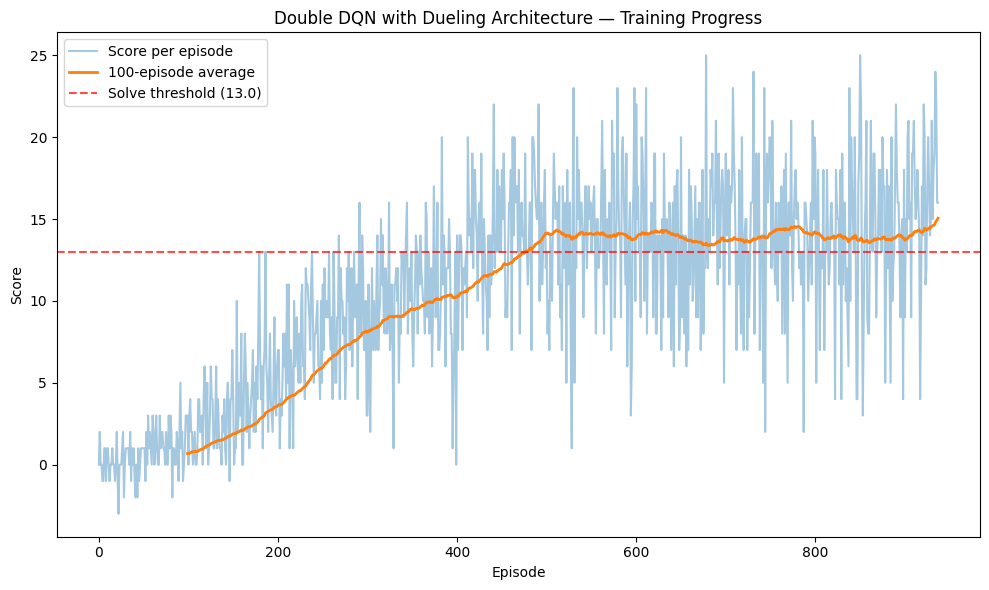

Plot saved to scores_plot.png


In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.arange(len(scores)), scores, alpha=0.4, label='Score per episode')

# Rolling average
if len(scores) >= 100:
    rolling = np.convolve(scores, np.ones(100)/100, mode='valid')
    ax.plot(np.arange(99, 99 + len(rolling)), rolling, linewidth=2, label='100-episode average')

ax.axhline(y=13.0, color='r', linestyle='--', alpha=0.7, label='Solve threshold (13.0)')
ax.set_xlabel('Episode')
ax.set_ylabel('Score')
ax.set_title('Double DQN with Dueling Architecture — Training Progress')
ax.legend()
plt.tight_layout()
plt.savefig('scores_plot.png', dpi=150)
plt.show()
print('Plot saved to scores_plot.png')

### 6. Test the Trained Agent

Load the saved checkpoint and run 100 greedy episodes (epsilon=0) to validate performance.

In [7]:
# Load trained weights
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth', weights_only=True))

test_scores = []
for i in range(100):
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.vector_observations[0]
    score = 0
    while True:
        action = agent.act(state, eps=0.0)  # greedy
        env_info = env.step(action)[brain_name]
        state = env_info.vector_observations[0]
        score += env_info.rewards[0]
        if env_info.local_done[0]:
            break
    test_scores.append(score)

print(f'Test Results over 100 episodes:')
print(f'  Average Score: {np.mean(test_scores):.2f}')
print(f'  Min: {np.min(test_scores):.0f}, Max: {np.max(test_scores):.0f}')
print(f'  Std: {np.std(test_scores):.2f}')

Test Results over 100 episodes:
  Average Score: 15.20
  Min: 0, Max: 27
  Std: 5.10


### 7. Close the Environment

In [8]:
env.close()